<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Parallel processing with Dask

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used**: 
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube.ipynb)
    * How to browse through the available [products and measurements](03_products_and_measurements.ipynb) of the eo2cube datacube 
    * How to [load data from the eo2cube datacube](04_loading_data_and_basic_xarray.ipynb)
    * How the data is stored and structured in a [xarray](05_advanced_xarray.ipynb)
    * How to [visualize the data](06_plotting.ipynb)
    * How to do a [basic analysis of remote sensing data](07_basic_analysis.ipynb) in the eo2cube environment

## Description
This notebook builds upon the notebook [07_basic_analysis](https://github.com/eo2cube/eo2cube_notebooks/blob/cornelia_dask/get_started/intro_to_eo2cube/07_basic_analysis.ipynb). In that notebook we presented a sample workflow for spatial data processing. In this notebook, we will perform a partially similar workflow. The main difference is that we will perform the calculation using dask. The following workflow will be applied:
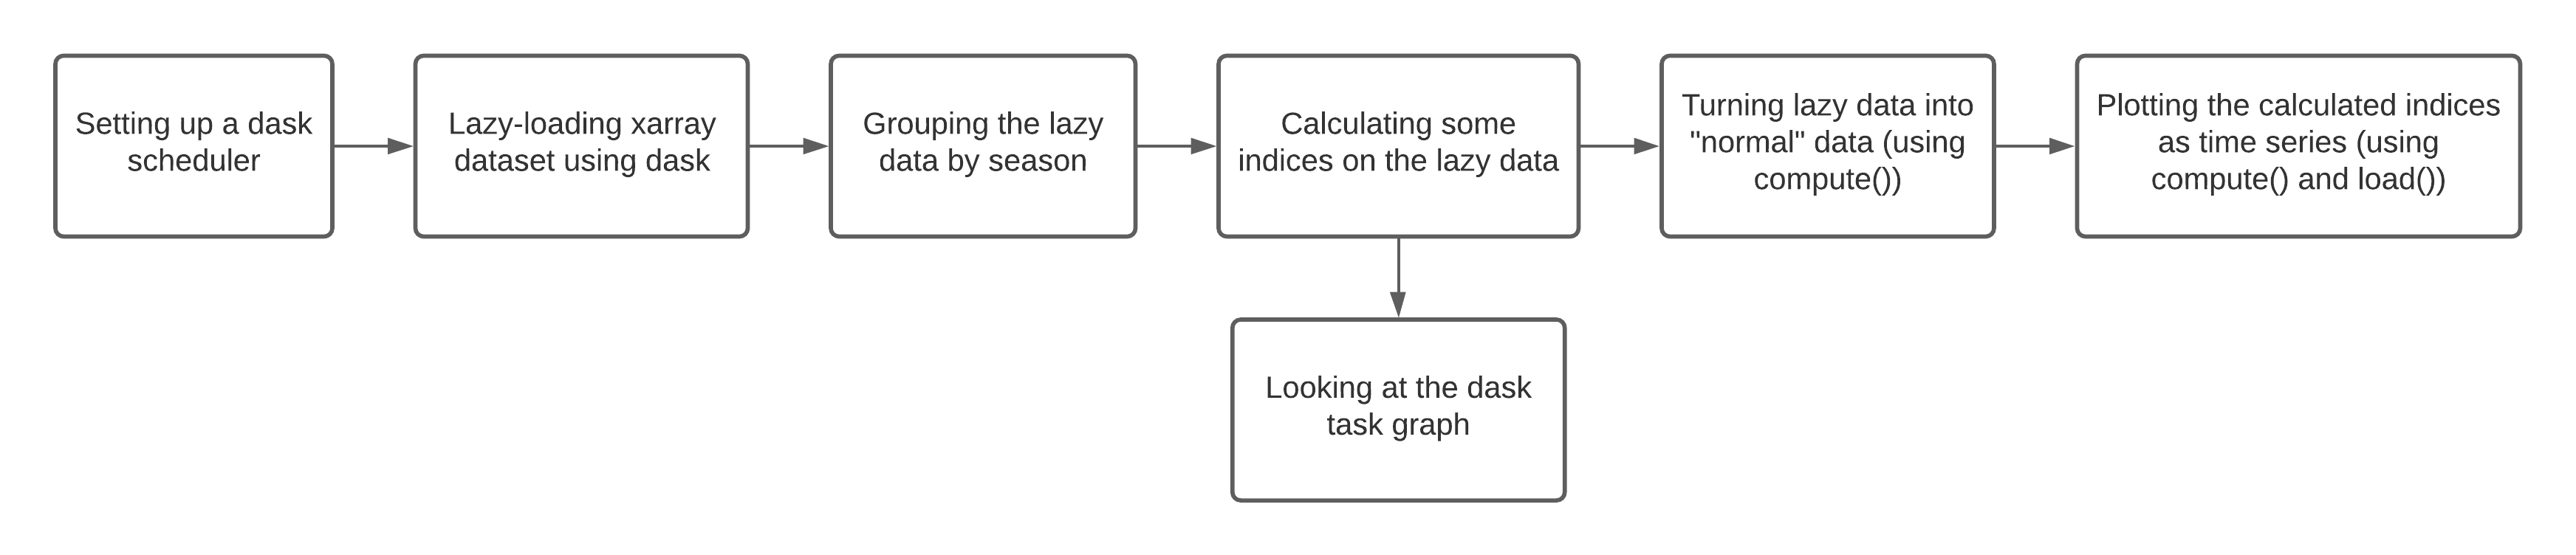

## What is Dask?
[Dask](https://dask.org/) is a library for parallel computing. It can be used to scale Pandas, NumPy, and Scikit-Learn workflows. Originally, datasets created with those libraries can only be scaled on a single machine. Dask internally uses the structures of Pandas, Numpy and Scikit-Learn. Thus, if you are familiar with those libraries, it will be easy to transform your "old" code in a new, scalable Dask-version of it. <br>
In this notebook, we will mainly work with [daskArray](https://docs.dask.org/en/latest/array.html) which is the dask-equivalent of NumPy ndarray.

## Package import and datacube connection

First of all we start with importing all the packages that are needed for our analysis.<br>
Most of the packages have already been introduced in the previous notebooks. The newly introduced package here is Dask.

In [22]:
import datacube

# dask
import dask
from dask.distributed import Client

# plotting
import graphviz
import seaborn as sns

# images
import matplotlib.pyplot as plt
import pandas as pd

Connecting to the datacube

In [3]:
dc = datacube.Datacube(app = '08_parallel_processing_with_dask', config = '/home/datacube/.datacube.conf')

## Dask Schedulers
### (Single machine scheduler vs. Distributed scheduler)
Dask can be used to scale computations across multiple computers (cluster). <br>
But it also can be used for parallel computing on a single computer. This enables computations that normally would have been too demanding for the used machine.<br>
For the following analysis we are using the distributed scheduler since we are working on a datacube.<br>

### Setting up Dask.distributed

To start the Dask Client, we use the Dask-plugin within the Phenocube.
To use it, just click on the orange Dask symbol on the left side of the window. Then click on the "+ New" Button. A new LocalCluster is created. <br> By clicking on the "Scale" button, the Client can be scaled (i.e. reducing the number of workers). <br>
Now, just drag and drop the cluster into this code and reduce the number of workers to 2.

In [4]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36221")
client

Client Scheduler: tcp://127.0.0.1:36221 Dashboard: http://127.0.0.1:36509/status,Cluster Workers: 3 Cores: 15 Memory: 71.31 GB


## Loading the data using dask
In the following, the data is loaded.
As you remeber from the previous notebooks a "normal" command for loading data looks somewhat like this: <br>
`
ds = dc.load(product = "s2_l2a_bavaria",
             measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"],
             longitude = [12.493, 12.509],
             latitude = [47.861, 47.868],
             time = ("2020-04-01", "2021-03-31"))
`
<br>
For loading data with dask, you just add the "dask_chunks"-parameter. <br>
This looks like this:

In [7]:
# Load Data
ds = dc.load(#product = "s2_l2a_burkinafaso",
             product = "s2_l2a_bavaria",
             measurements = ["blue", "green","red", "red_edge2", "nir", "narrow_nir"], #bavaria
             #measurements = ["blue", "green", "red", "veg6", "nir", "narrow_nir"], #burkina faso
             longitude = [12.493, 12.509], #bavaria
             latitude = [47.861, 47.868], #bavaria
             #longitude = [-3.1438, -2.83713], #burkina faso
             #latitude = [11.0745, 11.36368], #burkina faso
             time = ("2019-01-01", "2020-04-30"), #bavaria
             #time = ("2019-01-01", "2019-12-31"),
             dask_chunks={"time": 1, "x": 50, "y": 50} #bavaria
             #dask_chunks={"time": 1, "latitude": 50, "longitude":50} #burkina faso
            )

To understand what we have done here, lets first look at the dataset we loaded.

In [8]:
ds

<xarray.Dataset>
Dimensions:      (time: 479, x: 124, y: 84)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T10:07:21 ... 2020-04-30T10:...
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
Data variables:
    blue         (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (time, y, x) int16 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

You see that the xarray.Dataset consists of multiple [dask.array](https://docs.dask.org/en/latest/array.html) objects but we cannot see any values inside our data. <br>
This type of data is called "lazy data" as it is not loaded properly but in a "lazy" way without evaluated data values.

## Dask Chunks
The parameter that was added to the dc.load() command is called "dask_chunks". It defines in how many parts our original dataset will be splitted. As described in the previous notebooks, normally the dc.load() command produces a xarray dataset consisting of integer values.<br>
In our case, the dataset is split into smaller chunks. Since the data we are interested in is three dimensional, we also need to provide three dimensions for subdividing the data. <br>
The chunksize of the dask.arrays scales according to the provided values within the "dask_chunks" parameter.
<br>
In the following we will visualize the lazy-loaded data for the red band to get an even better feeling about our type of data.


In [9]:
# visualizing the dask chunks
ds.red.data

dask.array<dc_load_red, shape=(479, 84, 124), dtype=int16, chunksize=(1, 50, 50), chunktype=numpy.ndarray>

Here, the red band of our lazy dataset is shown. We see that our data has been devided into numerous chunks, each having the size we defined within the "dask_chunks" parameter in the dc.load() function. <br>
Looking at the memory size of the chunks compared to the complete array, the motivation for using dask becomes clear. Especially when working with large amounts of data, splitting the data into smaller chunks enables computations that would crash the cube environment when calculated over the complete array at once.

## Lazy operations
When working with large amounts of data, it makes sense to postpone loading the data as far back as possible. To do so, we can perform operations on lazy data directly, without loading its values. <br>
When we want to do a computation on lazy data, it makes sense to chain operations together and to just calculate the result right at the end (with the compute() function). <br>
In the [previous notebook](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb) you did some basic analysis. Now, this analysis will be repeated but using dask. Like already mentioned, the code will not differ alot since dask is build on numpy. The main difference is that in this case the calculation is performed in a "lazy" way. Thus, the resulting values are not calculated directly but will be on demand (using the compute() function).<br>

### Grouping the data by month and extracting the mean
We start with grouping our data by season and calculating the mean value for each pixel. <br>
As you may remember, `groupby('time.season')`creates four groups: 'DJF'(Dec, Jan, Feb), 'MAM' (Mar, Apr, May), 'JJA' (Jun, Jul, Aug) and 'SON' (Sep, Oct, Nov) <br>
**NOTE**: In notebook 7 we calculated the median on the seasonal values. Here we calculate the mean because the  `median()` function is not implemented on dask arrays.

In [11]:
# Group by Season and Calculate the seasonal Median.
ds_grp_dask = ds.groupby('time.season').mean()

print(ds_grp_dask)

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>


As you see, the data is now grouped into monthly timesteps but still in dask.array-format as is has not been computed/evaluated yet.

### Calculating indices on grouped, lazy-loaded data

In [15]:
#NDVI
ndvi_dask = (ds_grp_dask.nir - ds_grp_dask.red)/(ds_grp_dask.nir+ds_grp_dask.red)

# Tasseled Cap Wetness
wet_dask = 0.1509*ds_grp_dask.blue + 0.1973*ds_grp_dask.green + 0.3279*ds_grp_dask.red + 0.3406*ds_grp_dask.nir-0.711211-0.457212

# Tasseled Cap Green Vegetation
gvi_dask = -0.2848*ds_grp_dask.blue-0.2435*ds_grp_dask.green-0.5436*ds_grp_dask.red + 0.7243*ds_grp_dask.nir + 0.084011-0.180012

# Tasseled Cap Soil Brightness
sbi_dask = 0.332*ds_grp_dask.green + 0.603*ds_grp_dask.red + 0.675*ds_grp_dask.red_edge2 + 0.262*ds_grp_dask.narrow_nir #bavaria
#sbi_dask = 0.332*ds_grp_dask.green + 0.603*ds_grp_dask.red + 0.675*ds_grp_dask.veg6 + 0.262*ds_grp_dask.narrow_nir # burkina faso

After creating them, we need to add the calculated indices to our Dask dataset.

In [16]:
ds_grp_dask['ndvi']=ndvi_dask
ds_grp_dask['wet']=wet_dask
ds_grp_dask['gvi']=gvi_dask
ds_grp_dask['sbi']=sbi_dask
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    wet          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    gvi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    sbi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

We now calculated some indices based on lazy-loaded data. Since we have not used the compute() function, the indices are lazy-loaded dask.arrays as well.

## Task Graph
To get a better feeling for what happens when we chain tasks in dask, we now will have a look at the task graph using the `visualize()`function.
This produces a graph which shows all the tasks that dask needs to execute.<br>
If the graph is too large, an error occurs. In this case, just look at you working folder for a .png file. This should contain your produced graph. <br>
If the graph opens within the notebook, doubleclicking on it will enlarge it. 
<br>
<br>
**Note:** The visualization of the graph might take some time depending on the amount of data it is calculated on.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0657779 to fit


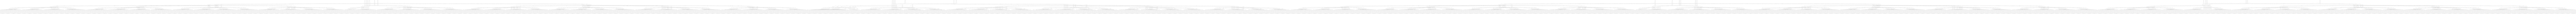

In [17]:
ds_grp_dask.red.data.visualize()

## Loading/ computing lazy data

### compute()

Lazy Dask arrays do not evaluate (e.g. contain actual values) until their calculation is initiated. The `compute()`-function triggers such an evaluation.<br>
It is important to note that `compute()`writes its results into memory. So only use it if the results will fit in it. If they are too large, it is possible to write them to disk directly. 
For dask Arrays the `to_hdf5()`command can be used (`my_dask_array.to_hdf5("myfile.hdf5")`) to do so. <br>
Running `compute()` might take some time depending on the size of your `DataArray` or `Dataset`.

In the following case, we will use the compute function, to visualize the calculated indices as a timeseries. <br>
The same has already been done in Notebook 7. The only difference is, that in this case we compute() the lazy data first.

In [20]:
ds_grp_dask_computed = ds_grp_dask.compute()
ds_grp_dask_computed

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 1.446e+03 1.458e+03 ... 1.517e+03
    green        (season, y, x) float64 1.392e+03 1.398e+03 ... 1.502e+03
    red          (season, y, x) float64 1.356e+03 1.368e+03 ... 1.418e+03
    red_edge2    (season, y, x) float64 1.37e+03 1.382e+03 ... 1.443e+03
    nir          (season, y, x) float64 1.374e+03 1.381e+03 ... 1.367e+03
    narrow_nir   (season, y, x) float64 1.33e+03 1.342e+03 ... 1.414e+03
    ndvi         (season, y, x) float64 0.006696 0.004723 ... -0.02041 -0.01836
    wet          (season, y, x) float64 1.404e+03 1.413e+03 ... 1.455e+03
    gvi          (season, y, x) float64 -492.5 -499.4 -503.8 ... -576.4 -578.6
    sbi          (season, y, x) float64 2.553e+03 2.573e+03 ... 2.698e+03

As you see, the values of the Data variables now have changed from `dask.array`to actual `int16`values. This data can now for example be plotted. <br>
**Note:** When you try to plot lazy loaded data directly (without applying the `compute()`function beforehand) the data will be computed automatically. Thus, plotting lazy loaded data will take some time due to the inherent computation process. <br>

### Plot Time Series
After computing the lazy data, we will now plot the ndvi, wet, gvi and sbi values for each season.

Text(0.5, 1.02, 'Seasonal Mean 2019')

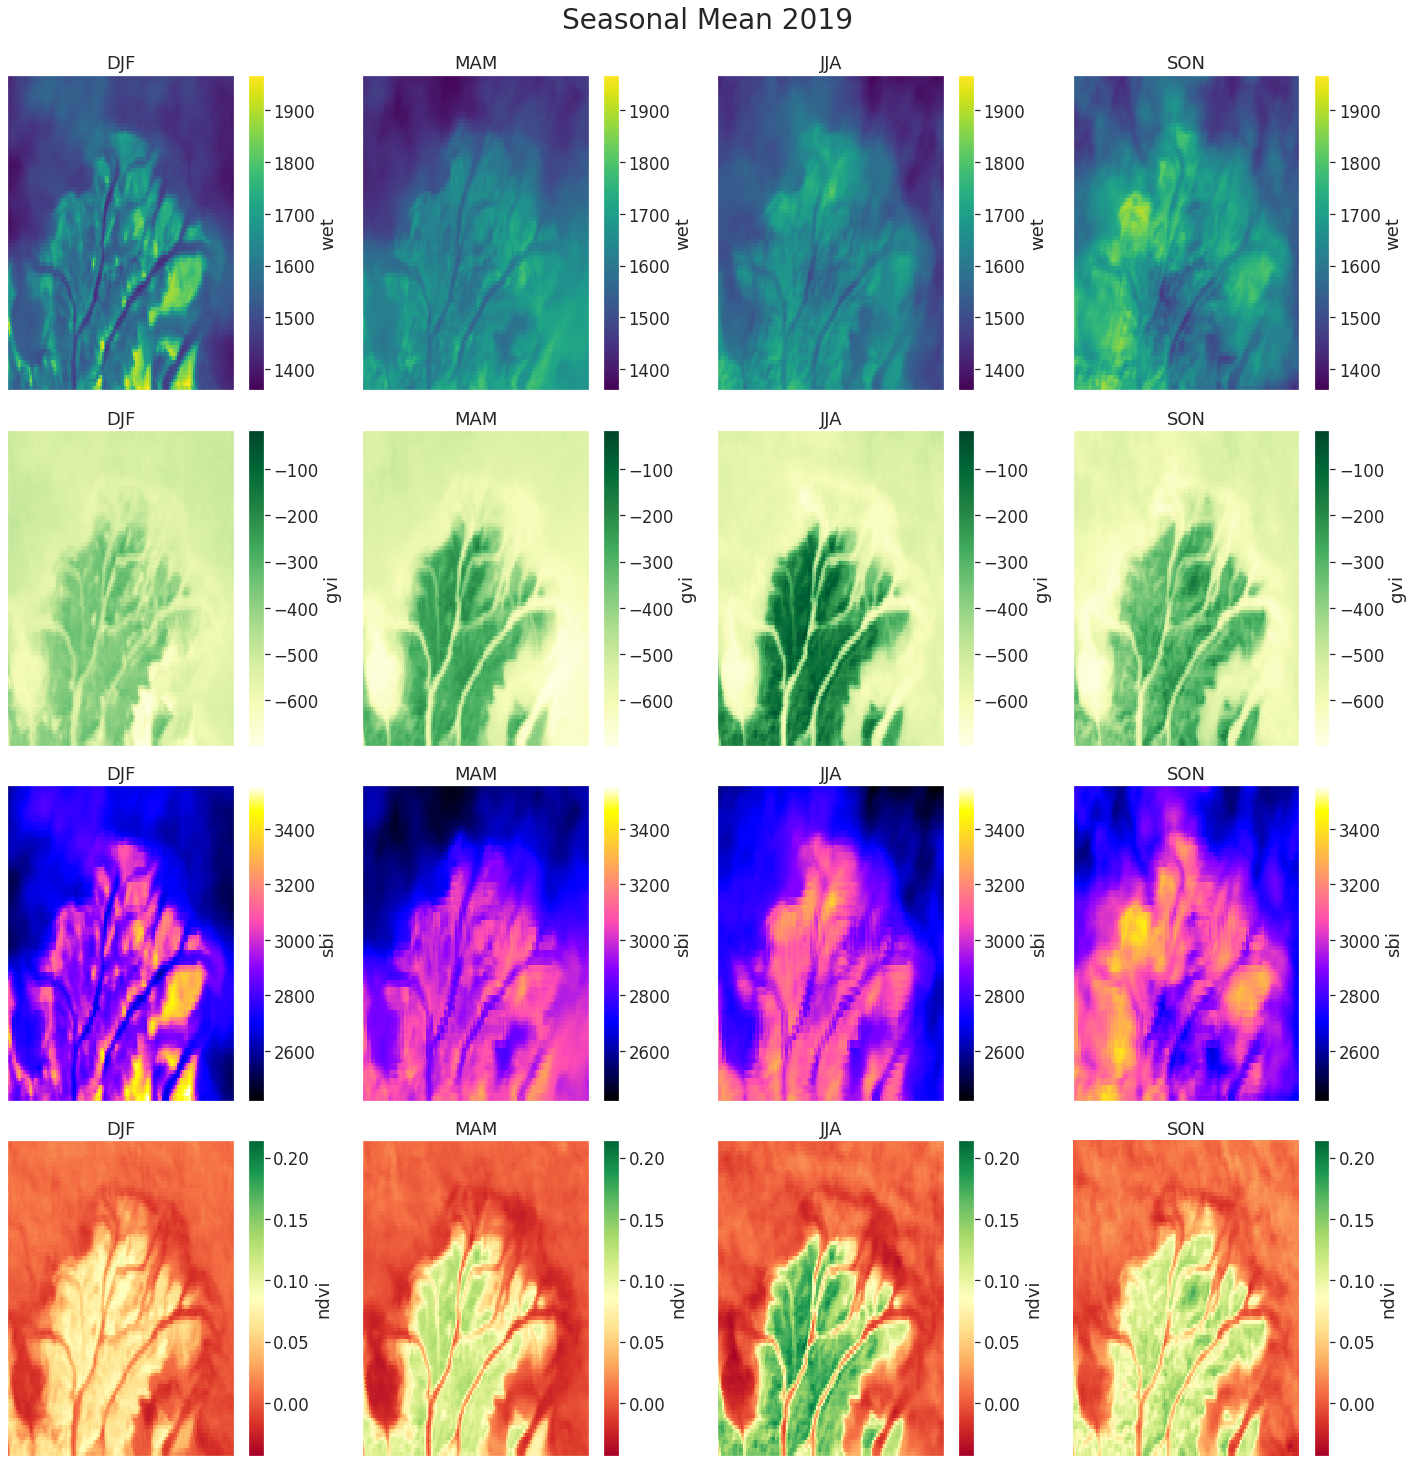

In [30]:
mylist = ["DJF", "MAM", "JJA", "SON"] #arrange seasons into our list
c = ['viridis','YlGn','gnuplot2','RdYlGn'] #the list of color maps

sns.set(font_scale=1.5) #scale the texts in plot to 1.5
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20)) #plot subplots

for i, sea in enumerate(mylist):
    ds_grp_dask_computed['wet'].sel(season=sea).plot(ax=axes[0,i], vmin=ds_grp_dask_computed.wet.min(), vmax=ds_grp_dask_computed.wet.max(), cmap=c[0], robust=True)                                      
    ds_grp_dask_computed['gvi'].sel(season=sea).plot(ax=axes[1,i], vmin=ds_grp_dask_computed.gvi.min(), vmax=ds_grp_dask_computed.gvi.max(), cmap=c[1], robust=True)
    ds_grp_dask_computed['sbi'].sel(season=sea).plot(ax=axes[2,i], vmin=ds_grp_dask_computed.sbi.min(), vmax=ds_grp_dask_computed.sbi.max(), cmap=c[2], robust=True)
    ds_grp_dask_computed['ndvi'].sel(season=sea).plot(ax=axes[3,i], vmin=ds_grp_dask_computed.ndvi.min(), vmax=ds_grp_dask_computed.ndvi.max(), cmap=c[3], robust=True)
    
for i, ax in enumerate(axes.flatten()):
    ax.set_title(mylist[i%4]) #plot subtitles
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([]) #empty x ticks
    ax.axes.get_yaxis().set_ticklabels([]) #empty y ticks
    ax.set_xlabel('') #empty x label
    ax.set_ylabel('') #empty y label
    
plt.axis("off") #remove all axis
plt.tight_layout() #adjust excessive padding
fig.suptitle('Seasonal Mean 2019', fontsize=28, y=1.02) #main plot title

### load()

Dask also provides the `load()`function as a second version to calculate lazy-loaded data. When using the load() command, we do not only get the calulated data as a return but also change the values in the lazy-loaded dataset to its calculated values. This is not true for the `compute()`command.

In [33]:
# original lazy-loaded data
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    wet          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    gvi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    sbi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

In [34]:
# calculating the gvi values using the compute() function
gvi_compute = ds_grp_dask.gvi.compute()

# and plotting the original data again
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    wet          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    gvi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    sbi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

In [35]:
# calculating the gvi values using the load() function
gvi_load = ds_grp_dask.gvi.load()

# and plotting the original data again
ds_grp_dask

<xarray.Dataset>
Dimensions:      (season: 4, x: 124, y: 84)
Coordinates:
  * y            (y) float64 5.308e+06 5.308e+06 ... 5.307e+06 5.307e+06
  * x            (x) float64 7.612e+05 7.612e+05 ... 7.624e+05 7.624e+05
    spatial_ref  int32 25832
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    green        (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    red_edge2    (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    nir          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    narrow_nir   (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ndvi         (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    wet          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    gvi          (season, y, x) float64 -492.5 -499.4 -503.8 ... -576.4 -578.6
    sbi          (season, y, x) float64 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

## Further Information
For further information about Dask, please have a look at the [Dask webpage](https://docs.dask.org/en/latest/).

## Recommended next steps

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/01_jupyter_introduction.ipynb)
2. [eo2cube](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/02_eo2cube_introduction.ipynb)
3. [Loading Data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/03_data_lookup_and_loading.ipynb)
4. [Xarray I: Data Structure](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/04_xarrayI_data_structure.ipynb)
5. [Xarray II: Index and Statistics](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/05_xarrayII.ipynb)
6. [Plotting data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb)
7. [Spatial analysis](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb)
8. ***Parallel processing with Dask (this notebook)***

The additional notebooks are designed for users to build up both basic and advanced skills which are not covered by the beginner's guide. Self-motivated users can go through them according to their own needs. They act as complements for the guide:
<br>

1. [Python's file management tools](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/I_file_management.ipynb)
2. [Image Processing basics using NumPy and Matplotlib](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/II_numpy_image_processing.ipynb)
3. [Vector Processing](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/III_process_vector_data.ipynb)
4. [Advanced Plotting](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb)

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks!</font>

https://doi.org/10.26186/145234 <br>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** February 2021